In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
from datetime import timedelta
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


In [2]:
c_01 = pd.read_csv("hpq_20230711134603.log", names=["date", "size"])
c_01

,date,size
0,2023-07-11T13:46:04+00:00,20
1,2023-07-11T13:46:05+00:00,20
2,2023-07-11T13:46:06+00:00,20
3,2023-07-11T13:46:08+00:00,20
4,2023-07-11T13:46:09+00:00,20
...,...,...
656,2023-07-11T13:58:15+00:00,39
657,2023-07-11T13:58:16+00:00,39
658,2023-07-11T13:58:17+00:00,39
659,2023-07-11T13:58:19+00:00,39


In [3]:
c_01["size"].sum()

15868

In [4]:
def parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("status")),pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 2] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [5]:
df_01 = parse("./simulation_k8s_01.log")

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_91846/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [9]:
df_01

,status,date,count
0,OK,2022-11-26 22:31:31,11
1,OK,2022-11-26 22:31:32,212
2,OK,2022-11-26 22:31:33,209
3,OK,2022-11-26 22:31:34,218
4,OK,2022-11-26 22:31:35,183
...,...,...,...
686,OK,2022-11-26 22:42:57,383
687,OK,2022-11-26 22:42:58,431
688,OK,2022-11-26 22:42:59,369
689,OK,2022-11-26 22:43:00,390


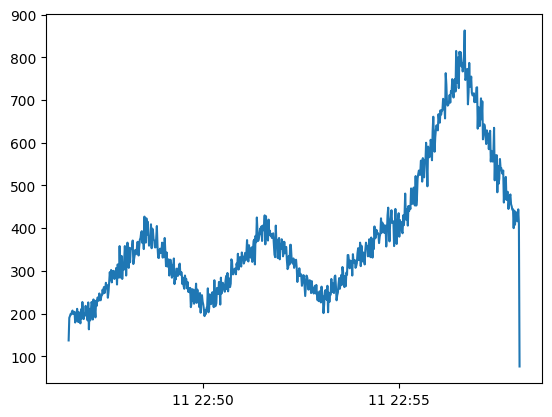

In [6]:
df_01_date = df_01["date"]
df_01_count = df_01["count"]
plt.plot(df_01_date, df_01_count)

In [7]:
def reg_tree() -> DecisionTreeRegressor:
    X = [
        [60],
        [100],
        [140],
        [175],
        [210],
        [255],
        [300],
        [330],
        [360],
        [390],
        [420],
        [460],
        [500],
        [540],
        [580],
        [610],
        [640],
        [670],
        [700],
        [730],
        [760],
        [790],
        [820],
        [850],
        [880],
        [910],
        [940],
        [970],
        [1000],
        [1030],
        [1060],
    ]

    y = [
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
    ]

    return DecisionTreeRegressor().fit(X, y)

In [8]:
def reg_tree_loop(ser: List[List[float]], batch_size = 50) -> List[float]:
    return [max(reg_tree().predict(np.array(ser[index-batch_size:index]))) for index in range(len(ser))[batch_size:]]

In [13]:
df_01_date

0     2022-11-26 22:31:31
1     2022-11-26 22:31:32
2     2022-11-26 22:31:33
3     2022-11-26 22:31:34
4     2022-11-26 22:31:35
              ...        
686   2022-11-26 22:42:57
687   2022-11-26 22:42:58
688   2022-11-26 22:42:59
689   2022-11-26 22:43:00
690   2022-11-26 22:43:01
Name: date, Length: 691, dtype: datetime64[ns]

In [14]:
df_01_count

0       11
1      212
2      209
3      218
4      183
      ... 
686    383
687    431
688    369
689    390
690    373
Name: count, Length: 691, dtype: int64

In [15]:
fuzzy_result = reg_tree_loop(df_01_count.to_numpy().reshape(-1, 1))

In [16]:
fuzzy_result

[9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 

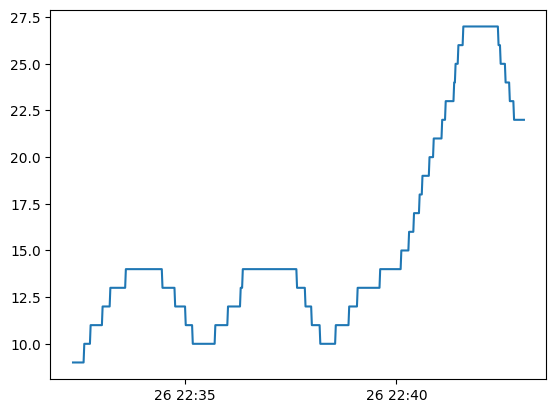

In [23]:
plt.plot(df_01_date[50:], fuzzy_result)

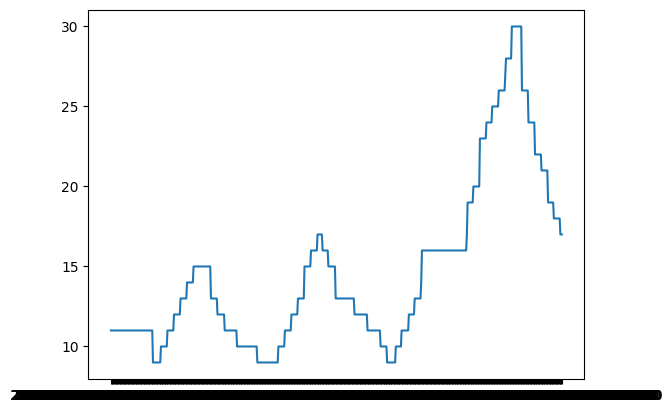

In [22]:
pred_cluster_size = c_01["size"]
pred_cluster_date = c_01["date"]
plt.plot(pred_cluster_date, pred_cluster_size)

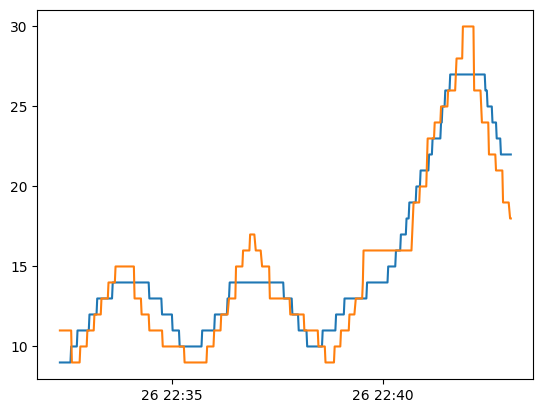

In [54]:
plt.plot(df_01_date[50:], fuzzy_result)
plt.plot([datetime.fromisoformat(d) + timedelta(hours=9) + timedelta(seconds=10) for d in pred_cluster_date][43:-10], pred_cluster_size[43:-10])

In [47]:
df_01_date[50:]

50    2022-11-26 22:32:21
51    2022-11-26 22:32:22
52    2022-11-26 22:32:23
53    2022-11-26 22:32:24
54    2022-11-26 22:32:25
              ...        
686   2022-11-26 22:42:57
687   2022-11-26 22:42:58
688   2022-11-26 22:42:59
689   2022-11-26 22:43:00
690   2022-11-26 22:43:01
Name: date, Length: 641, dtype: datetime64[ns]

In [53]:
[datetime.fromisoformat(d) + timedelta(hours=9) + timedelta(seconds=10) for d in pred_cluster_date][43:-10]

[datetime.datetime(2022, 11, 26, 22, 32, 21, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 22, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 23, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 24, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 25, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 27, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 28, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 29, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 30, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 31, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 32, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 33, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 26, 22, 32, 34, tzinfo=datetime.timezone.utc),
 datetime.da

In [55]:
from sklearn.metrics import mean_squared_error
mean_squared_error(fuzzy_result, pred_cluster_size[43:-10])

ValueError: Found input variables with inconsistent numbers of samples: [641, 570]

In [56]:
df_01

,status,date,count
0,OK,2022-11-26 22:31:31,11
1,OK,2022-11-26 22:31:32,212
2,OK,2022-11-26 22:31:33,209
3,OK,2022-11-26 22:31:34,218
4,OK,2022-11-26 22:31:35,183
...,...,...,...
686,OK,2022-11-26 22:42:57,383
687,OK,2022-11-26 22:42:58,431
688,OK,2022-11-26 22:42:59,369
689,OK,2022-11-26 22:43:00,390


In [57]:
c_01

,date,size
0,2022-11-26T13:31:22+00:00,11
1,2022-11-26T13:31:23+00:00,11
2,2022-11-26T13:31:25+00:00,11
3,2022-11-26T13:31:26+00:00,11
4,2022-11-26T13:31:27+00:00,11
...,...,...
618,2022-11-26T13:42:57+00:00,18
619,2022-11-26T13:42:59+00:00,18
620,2022-11-26T13:43:00+00:00,17
621,2022-11-26T13:43:01+00:00,17


In [73]:
df_01["date"][0]

Timestamp('2022-11-26 22:31:31')

In [9]:
replaced_c_01 = c_01
replaced_c_01["date"] = pd.to_datetime(c_01["date"], utc = False) + pd.to_timedelta(9, unit='h')
replaced_c_01

,date,size
0,2023-07-11 22:46:04+00:00,20
1,2023-07-11 22:46:05+00:00,20
2,2023-07-11 22:46:06+00:00,20
3,2023-07-11 22:46:08+00:00,20
4,2023-07-11 22:46:09+00:00,20
...,...,...
656,2023-07-11 22:58:15+00:00,39
657,2023-07-11 22:58:16+00:00,39
658,2023-07-11 22:58:17+00:00,39
659,2023-07-11 22:58:19+00:00,39


In [10]:
replaced_df_01 = df_01
replaced_df_01["date"] = pd.to_datetime(df_01["date"], utc=True)
replaced_df_01

,status,date,count
0,OK,2023-07-11 22:46:35+00:00,137
1,OK,2023-07-11 22:46:36+00:00,190
2,OK,2023-07-11 22:46:37+00:00,194
3,OK,2023-07-11 22:46:38+00:00,199
4,OK,2023-07-11 22:46:39+00:00,198
...,...,...,...
686,OK,2023-07-11 22:58:01+00:00,419
687,OK,2023-07-11 22:58:02+00:00,416
688,OK,2023-07-11 22:58:03+00:00,444
689,OK,2023-07-11 22:58:04+00:00,412


In [11]:
merged_01 = pd.merge(replaced_df_01, replaced_c_01, left_on="date", right_on="date")
merged_01

,status,date,count,size
0,OK,2023-07-11 22:46:35+00:00,137,34
1,OK,2023-07-11 22:46:36+00:00,190,34
2,OK,2023-07-11 22:46:37+00:00,194,34
3,OK,2023-07-11 22:46:39+00:00,198,34
4,OK,2023-07-11 22:46:40+00:00,204,34
...,...,...,...,...
617,OK,2023-07-11 22:58:01+00:00,419,39
618,OK,2023-07-11 22:58:02+00:00,416,39
619,OK,2023-07-11 22:58:03+00:00,444,39
620,OK,2023-07-11 22:58:04+00:00,412,39


In [12]:
merged_02 = merged_01
merged_02["expected_size"] = merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
merged_02

,status,date,count,size,expected_size
0,OK,2023-07-11 22:46:35+00:00,137,34,6.0
1,OK,2023-07-11 22:46:36+00:00,190,34,7.0
2,OK,2023-07-11 22:46:37+00:00,194,34,8.0
3,OK,2023-07-11 22:46:39+00:00,198,34,8.0
4,OK,2023-07-11 22:46:40+00:00,204,34,8.0
...,...,...,...,...,...
617,OK,2023-07-11 22:58:01+00:00,419,39,14.0
618,OK,2023-07-11 22:58:02+00:00,416,39,14.0
619,OK,2023-07-11 22:58:03+00:00,444,39,15.0
620,OK,2023-07-11 22:58:04+00:00,412,39,14.0


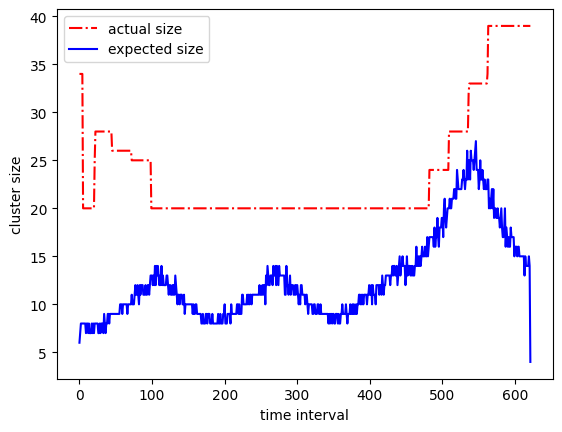

In [13]:
plt.xlabel(xlabel="time interval")
plt.ylabel(ylabel="cluster size")
plt.plot([k for k, v in enumerate(merged_02["date"])], merged_02["size"], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(merged_02["date"])], merged_02["expected_size"], color="blue", label='expected size')
plt.legend()
plt.savefig("fb2015_k8s_1.png")

In [15]:
mean_squared_error(merged_02["size"], merged_02["expected_size"])

150.9565916398714

In [7]:
def fuzzy_loop(ser: List[float], batch_size = 50) -> List[float]:
    return [nk.entropy_fuzzy(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [8]:
def dist_loop(ser: List[float], batch_size = 50) -> List[float]:
    return [nk.entropy_distribution(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [13]:
def ap_loop(ser: List[float], batch_size = 50) -> List[float]:
    return [nk.entropy_approximate(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [9]:
fuzzy_loop_result = fuzzy_loop(df_01_count)

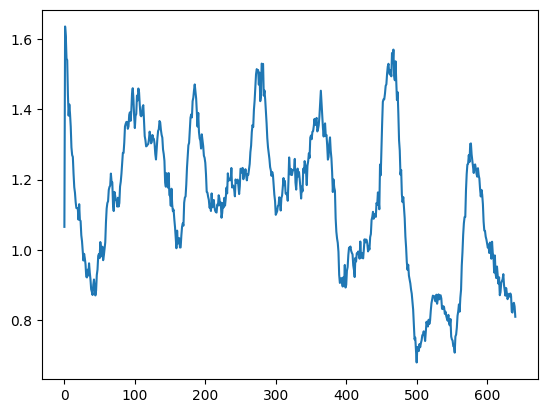

In [10]:
plt.plot(fuzzy_loop_result)

In [11]:
dist_loop_result = dist_loop(df_01_count)

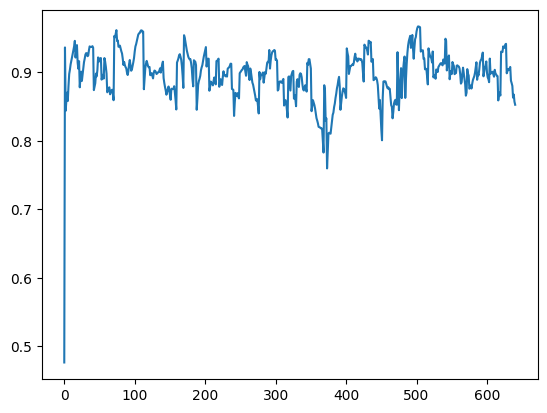

In [12]:
plt.plot(dist_loop_result)

In [14]:
ap_loop_result = ap_loop(df_01_count)

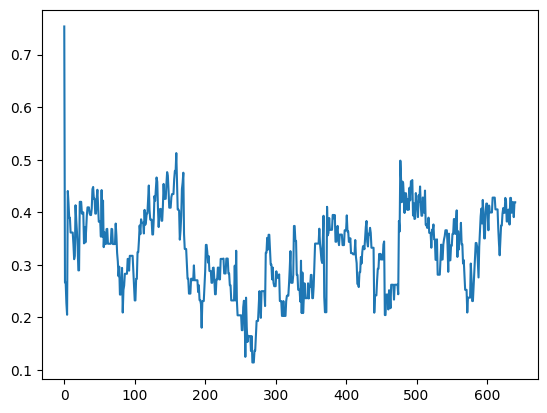

In [15]:
plt.plot(ap_loop_result)

In [16]:
from hurst import compute_Hc, random_walk

In [32]:
random_walk_01 = random_walk(10000, min_lookback=1, max_lookback=1000, cumprod=True)

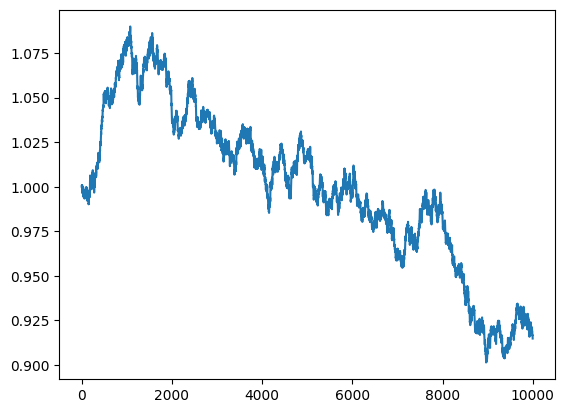

In [33]:
plt.plot(random_walk_01)

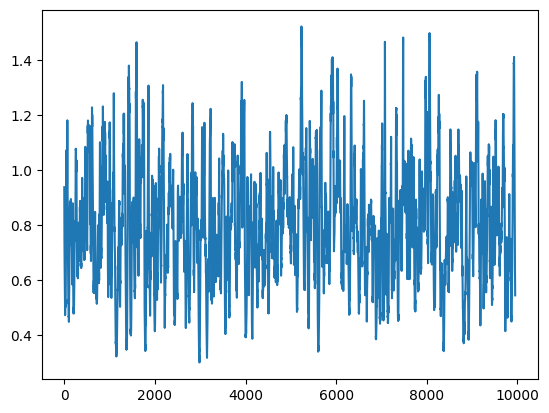

In [31]:
random_walk_01_fuzzy = fuzzy_loop(random_walk_01)
plt.plot(random_walk_01_fuzzy)

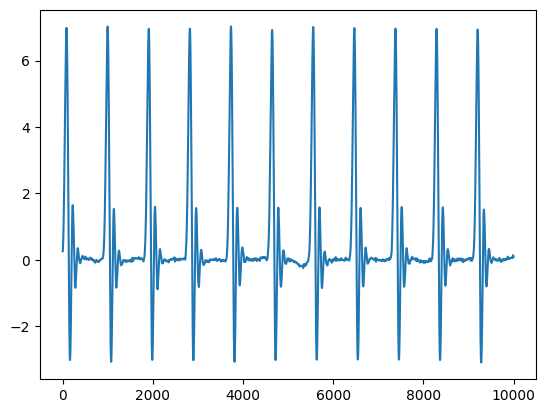

In [34]:
ecg_sim = nk.ecg_simulate(duration=10, method="simple")
plt.plot(ecg_sim)

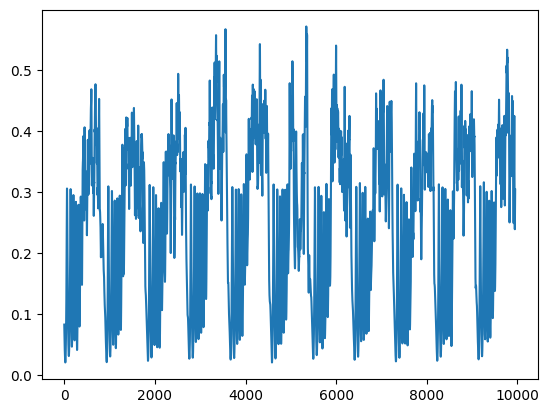

In [35]:
ecg_sim_fuzzy = fuzzy_loop(ecg_sim)
plt.plot(ecg_sim_fuzzy)

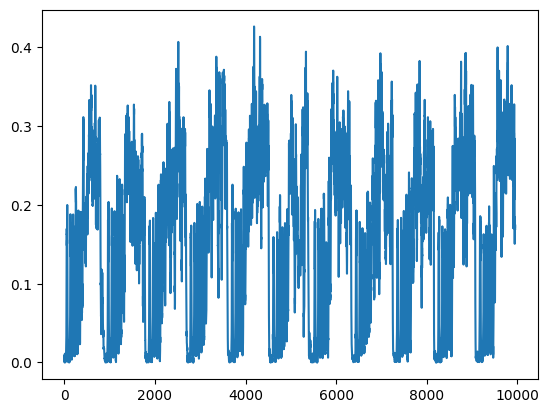

In [36]:
ecg_sim_ap = ap_loop(ecg_sim)
plt.plot(ecg_sim_ap)

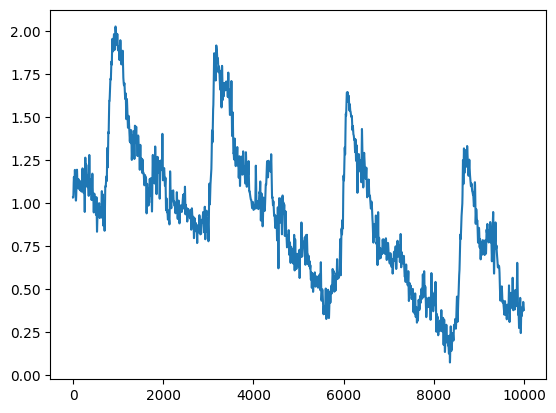

In [43]:
eda1 = nk.eda_simulate(duration=10, length=100, scr_number=4, drift=-0.1, noise=0.1)
plt.plot(eda1)

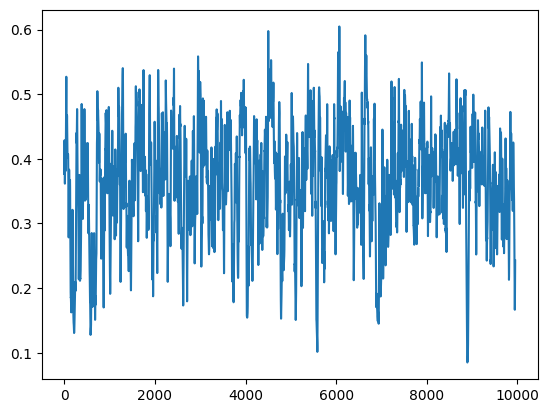

In [40]:
eda1_fuzzy = fuzzy_loop(eda1)
plt.plot(eda1_fuzzy)

In [44]:
def rw(x):
    y = 0
    result = []
    for _ in x:
        result.append(y)
        y += np.random.normal(scale=1)
    return np.array(result)

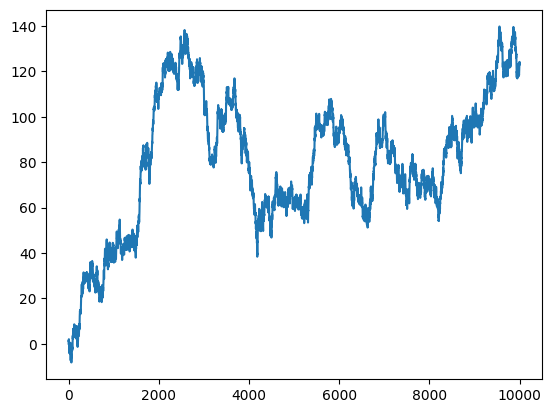

In [98]:
raw_data_01 = rw(np.linspace(0, 10000, 10000))
plt.plot(raw_data_01)

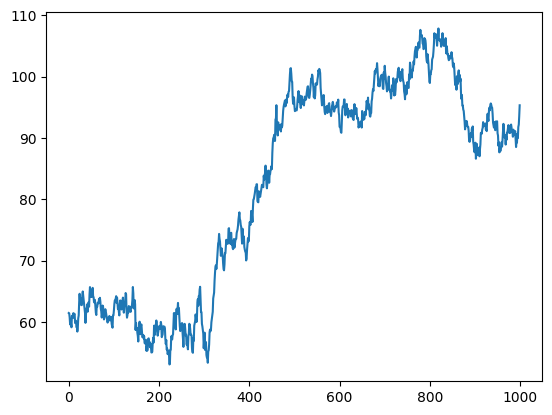

In [115]:
plt.plot(raw_data_01[5000:6000])

In [116]:
data_01 = raw_data_01[5000:6000]

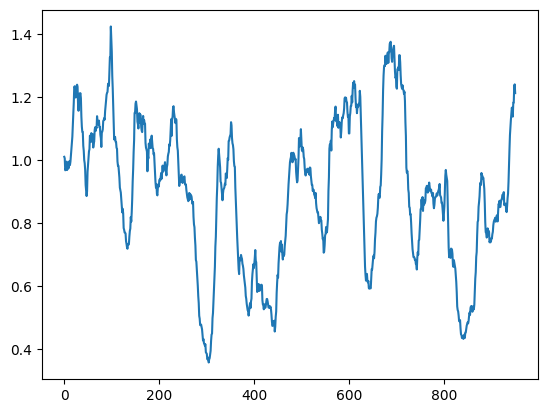

In [117]:
data_01_fuzzy = fuzzy_loop(data_01)
plt.plot(data_01_fuzzy)

In [68]:
len(data_01_fuzzy)

450

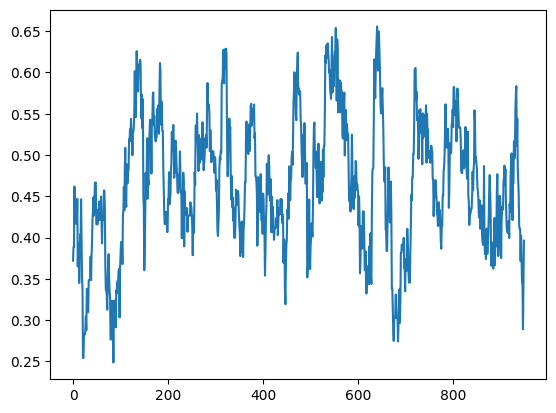

In [105]:
data_01_ap = ap_loop(data_01)
plt.plot(data_01_ap)

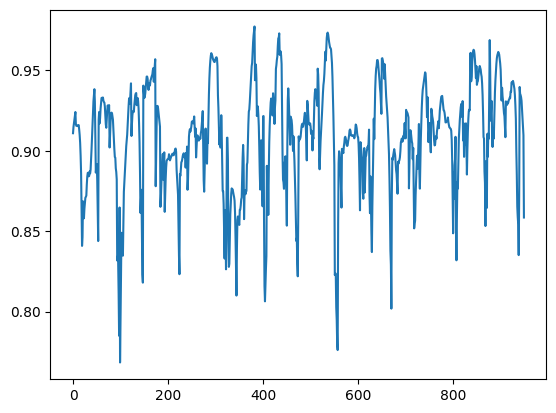

In [106]:
data_01_dist = dist_loop(data_01)
plt.plot(data_01_dist)

In [69]:
len(data_01[:50]), len(data_01_fuzzy)

(50, 450)

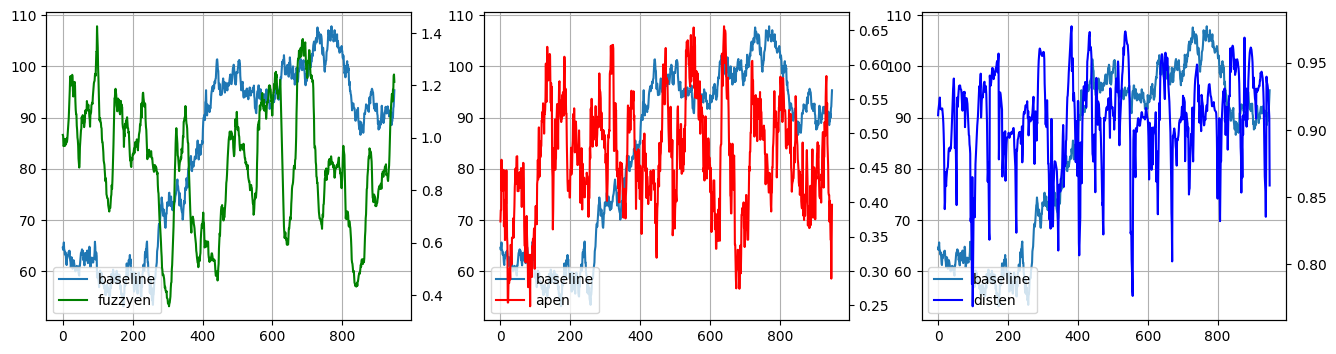

In [125]:
x2_fig, x2_axes = plt.subplots(1, 3, figsize=(16, 4))
x2_ln1 = x2_axes[0].plot(data_01[50:],label='baseline')

x2_ax1 = x2_axes[0].twinx()
x2_ln2 = x2_ax1.plot(data_01_fuzzy, color='green', label="fuzzyen")

x2_h1, x2_l1 = x2_axes[0].get_legend_handles_labels()
x2_h2, x2_l2 = x2_ax1.get_legend_handles_labels()
x2_axes[0].legend(x2_h1+x2_h2, x2_l1+x2_l2, loc='lower left')

x2_axes[0].grid(True)

x2_rn1 = x2_axes[1].plot(data_01[50:],label='baseline')

x2_ax2 = x2_axes[1].twinx()
x2_rn2 = x2_ax2.plot(data_01_ap, color='red', label="apen")

x2_h3, x2_l3 = x2_axes[1].get_legend_handles_labels()
x2_h4, x2_l4 = x2_ax2.get_legend_handles_labels()
x2_axes[1].legend(x2_h3+x2_h4, x2_l3+x2_l4, loc='lower left')

x2_axes[1].grid(True)

x3_rn1 = x2_axes[2].plot(data_01[50:],label='baseline')

x3_ax2 = x2_axes[2].twinx()
x3_rn2 = x3_ax2.plot(data_01_dist, color='blue', label="disten")

x3_h3, x3_l3 = x2_axes[2].get_legend_handles_labels()
x3_h4, x3_l4 = x3_ax2.get_legend_handles_labels()
x2_axes[2].legend(x3_h3+x3_h4, x3_l3+x3_l4, loc='lower left')

x2_axes[2].grid(True)
plt.savefig("fuzzy_vs_ap_vs_dist_2.png")

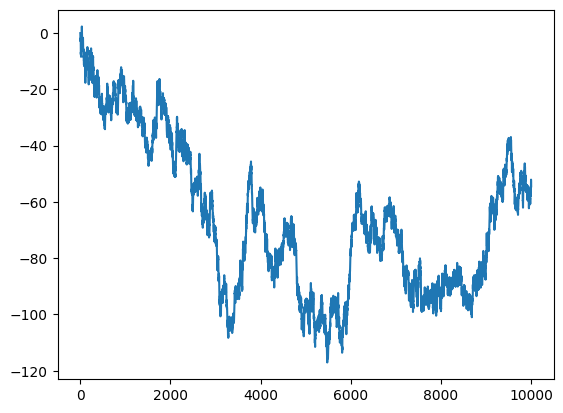

In [119]:
raw_data_02 = rw(np.linspace(0, 10000, 10000))
plt.plot(raw_data_02)

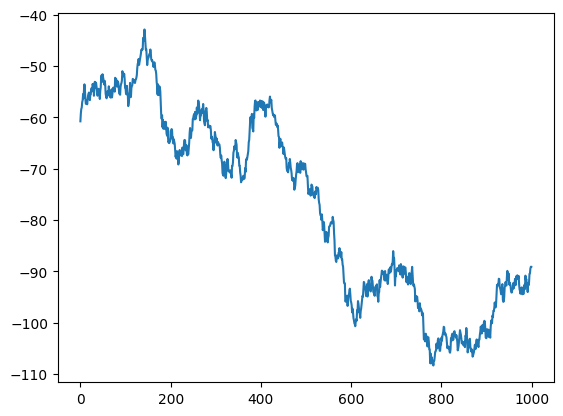

In [120]:
data_02 = raw_data_02[2500:3500]
plt.plot(data_02)

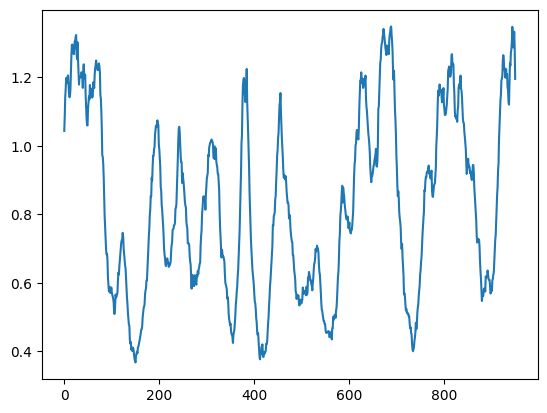

In [121]:
data_02_fuzzy = fuzzy_loop(data_02)
plt.plot(data_02_fuzzy)

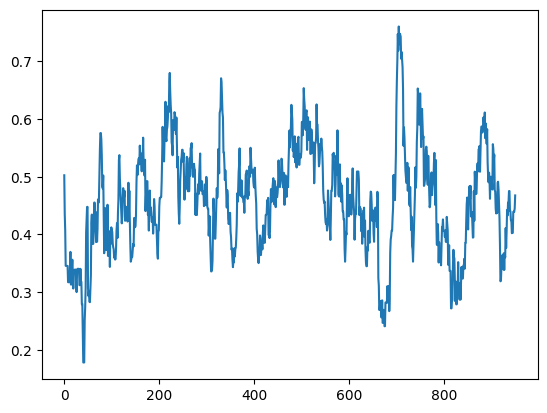

In [122]:
data_02_ap = ap_loop(data_02)
plt.plot(data_02_ap)

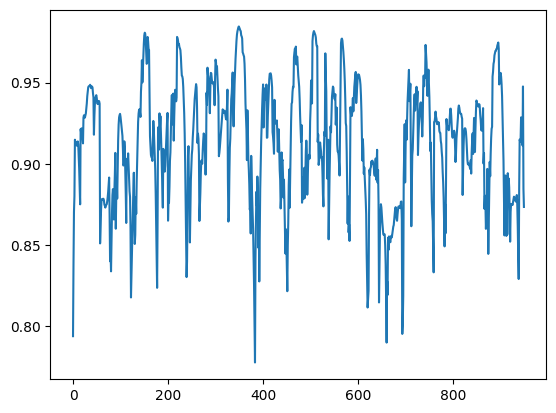

In [123]:
data_02_dist = dist_loop(data_02)
plt.plot(data_02_dist)

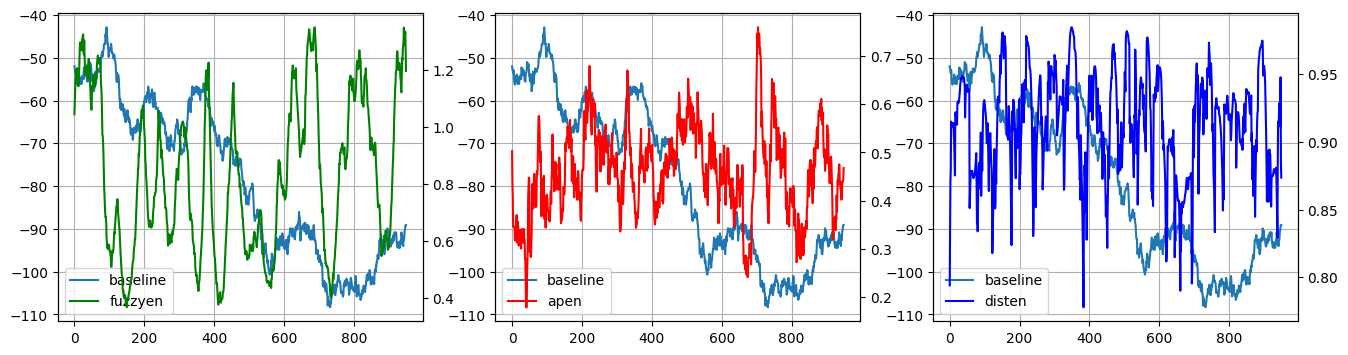

In [126]:
x2_fig, x2_axes = plt.subplots(1, 3, figsize=(16, 4))
x2_ln1 = x2_axes[0].plot(data_02[50:],label='baseline')

x2_ax1 = x2_axes[0].twinx()
x2_ln2 = x2_ax1.plot(data_02_fuzzy, color='green', label="fuzzyen")

x2_h1, x2_l1 = x2_axes[0].get_legend_handles_labels()
x2_h2, x2_l2 = x2_ax1.get_legend_handles_labels()
x2_axes[0].legend(x2_h1+x2_h2, x2_l1+x2_l2, loc='lower left')

x2_axes[0].grid(True)

x2_rn1 = x2_axes[1].plot(data_02[50:],label='baseline')

x2_ax2 = x2_axes[1].twinx()
x2_rn2 = x2_ax2.plot(data_02_ap, color='red', label="apen")

x2_h3, x2_l3 = x2_axes[1].get_legend_handles_labels()
x2_h4, x2_l4 = x2_ax2.get_legend_handles_labels()
x2_axes[1].legend(x2_h3+x2_h4, x2_l3+x2_l4, loc='lower left')

x2_axes[1].grid(True)

x3_rn1 = x2_axes[2].plot(data_02[50:],label='baseline')

x3_ax2 = x2_axes[2].twinx()
x3_rn2 = x3_ax2.plot(data_02_dist, color='blue', label="disten")

x3_h3, x3_l3 = x2_axes[2].get_legend_handles_labels()
x3_h4, x3_l4 = x3_ax2.get_legend_handles_labels()
x2_axes[2].legend(x3_h3+x3_h4, x3_l3+x3_l4, loc='lower left')

x2_axes[2].grid(True)
plt.savefig("fuzzy_vs_ap_vs_dist_1.png")